<a href="https://colab.research.google.com/github/solanki1993/Spiking-Neural-Networks-SNNs-with-PyTorch-/blob/main/Spiking_Neural_Network_(SNN)_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
 
import matplotlib.pyplot as plt
 
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
 


In [2]:

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from:
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
 
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
 
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
 
def train_many_epochs(model):
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
 
    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
 
    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
 
def test(model, device, test_set_loader):
    # This method is derived from:
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
 
    model.eval()
    test_loss = 0
    correct = 0
 
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
 
def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(
        data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(
        data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set
 


In [3]:
batch_size = 1000
DATA_PATH = './data'
 
training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Use GPU whever possible!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [5]:
class SpikingNeuronLayerRNN(nn.Module):
 
    def __init__(
        self, device, n_inputs=28*28, n_hidden=100, 
        decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5
    ):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
 
        self.fc = nn.Linear(n_inputs, n_hidden)
 
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
 
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
 
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)
 
    def forward(self, x):
        """
        Call the neuron at every time step.
{1}
        x: activated_neurons_below
{1}
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
 
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
 
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
 
        # 3. We compute the activation of the neuron to find its output value,
        #    but before the activation, there is also a negative bias 
        #    that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
 
        # 4. If the neuron fires, the activation of the 
        #    neuron is subtracted to its inner state
        #    (and with an extra penalty for increase refractory time),
        #    because it discharges naturally so it shouldn't fire twice.
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - do_penalize_gate * (
            self.penalty_threshold/self.threshold * inner_excitation)
 
        # 5. The outer excitation has a negative part after the positive part.
        outer_excitation = outer_excitation 
        # + torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
 
        # 6. Setting internal values before returning.
        #    And the returning value is the one of the previous time step to delay
        #    activation of 1 time step of "processing" time. 
        #    For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
 
 
class InputDataToSpikingPerceptronLayer(nn.Module):
 
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
 
        self.reset_state()
        self.to(self.device)
 
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
 
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
 
 
class OutputDataToSpikingPerceptronLayer(nn.Module):
 
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a 
        regular neural net as a layer. Otherwise, sum may be numerically
        more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
 
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
 
 
class SpikingNet(nn.Module):
 
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
 
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
 
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
 
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
 
        self.output_conversion = OutputDataToSpikingPerceptronLayer(
            average_output=False)  # Sum on outputs.
 
        self.to(self.device)
 
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
 
        out = []
 
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
 
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
 
            # We take inner state of layer 2 because it's 
            # pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
 
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
 
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [
            all_layer2_states, all_layer2_outputs]]
 
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)
 
    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)
 
        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu(
                ).numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu(
                ).numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)
 
        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu(
            ).numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu(
            ).numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()
 
class NonSpikingNet(nn.Module):
 
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)
 
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)


Training a Spiking Neural Network

In [6]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(spiking_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.363121 Accuracy: 9.50%
Train Epoch: 1 [10000/60000 (17%)] Loss: 2.204307 Accuracy: 19.50%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.775968 Accuracy: 45.80%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.764085 Accuracy: 73.70%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.541237 Accuracy: 81.60%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.491706 Accuracy: 85.10%


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0004, Accuracy: 8759/10000 (87.59%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.429493 Accuracy: 86.80%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.390172 Accuracy: 88.70%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.390195 Accuracy: 88.80%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.413359 Accuracy: 86.40%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.317252 Accuracy: 90.60%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.316337 Accuracy: 90.20%

Test set: Average loss: 0.0003, Accuracy: 9048/10000 (90.48%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.389367 Accuracy: 89.20%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.341049 Accuracy: 89.30%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.329650 Accuracy: 90.80%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.343552 Accuracy: 89.50%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.340214 Accuracy: 89.10%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.328137 Accuracy: 90.20%

Test set: Average loss: 0.0003, Accuracy: 9056/10000 (90.56%)



Training a Feedforward Neural Network just for comparison

In [7]:
non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.293560 Accuracy: 11.70%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.865152 Accuracy: 64.10%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.243753 Accuracy: 74.30%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.910626 Accuracy: 79.20%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.660909 Accuracy: 85.00%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.593900 Accuracy: 84.40%


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0005, Accuracy: 8674/10000 (86.74%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.486963 Accuracy: 88.50%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.494788 Accuracy: 87.30%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.540681 Accuracy: 86.70%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.490682 Accuracy: 87.40%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.461070 Accuracy: 88.30%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.482710 Accuracy: 86.80%

Test set: Average loss: 0.0004, Accuracy: 8862/10000 (88.62%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.406008 Accuracy: 89.40%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.399396 Accuracy: 89.70%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.428763 Accuracy: 89.40%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.431578 Accuracy: 88.60%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.453803 Accuracy: 87.70%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.421047 Accuracy: 88.30%

Test set: Average loss: 0.0004, Accuracy: 8902/10000 (89.02%)



To check how the Neurons spiked

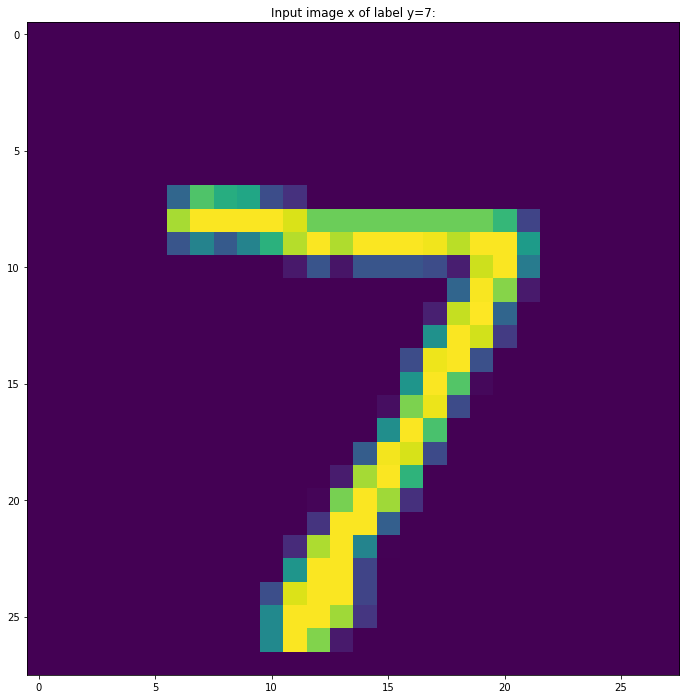

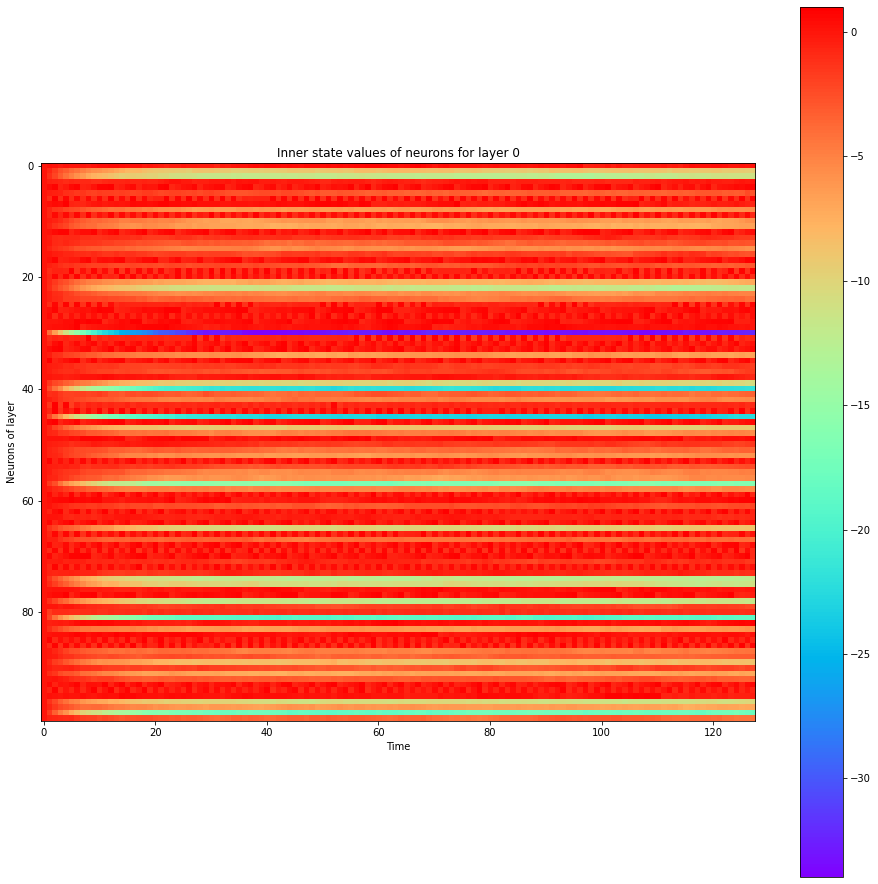

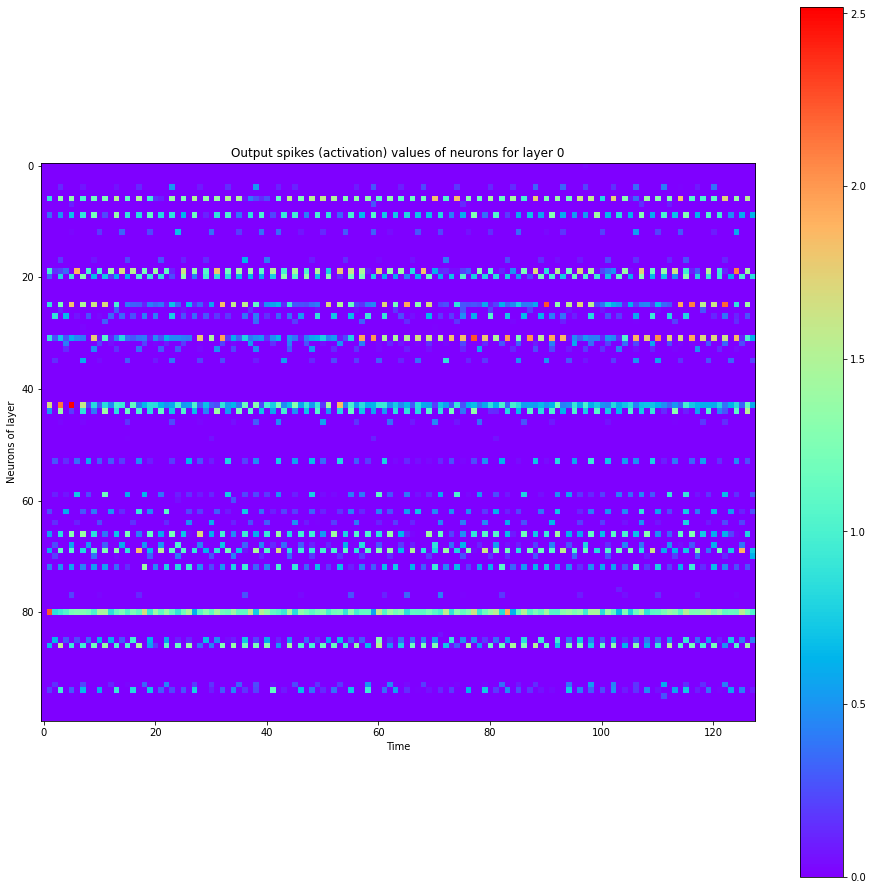

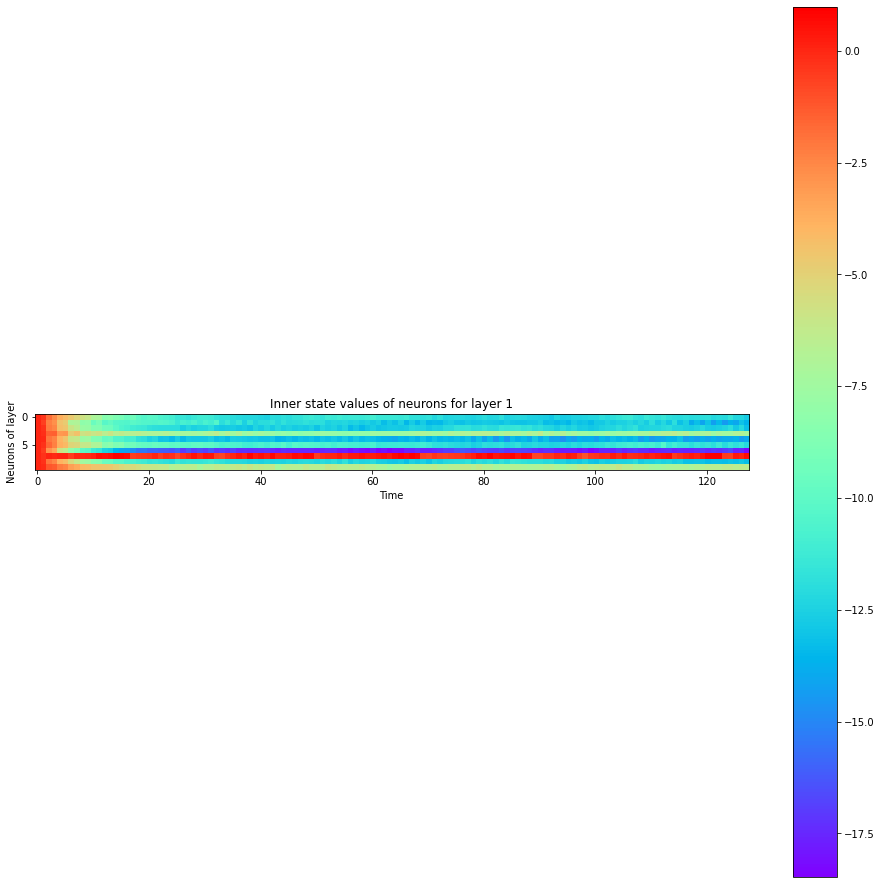

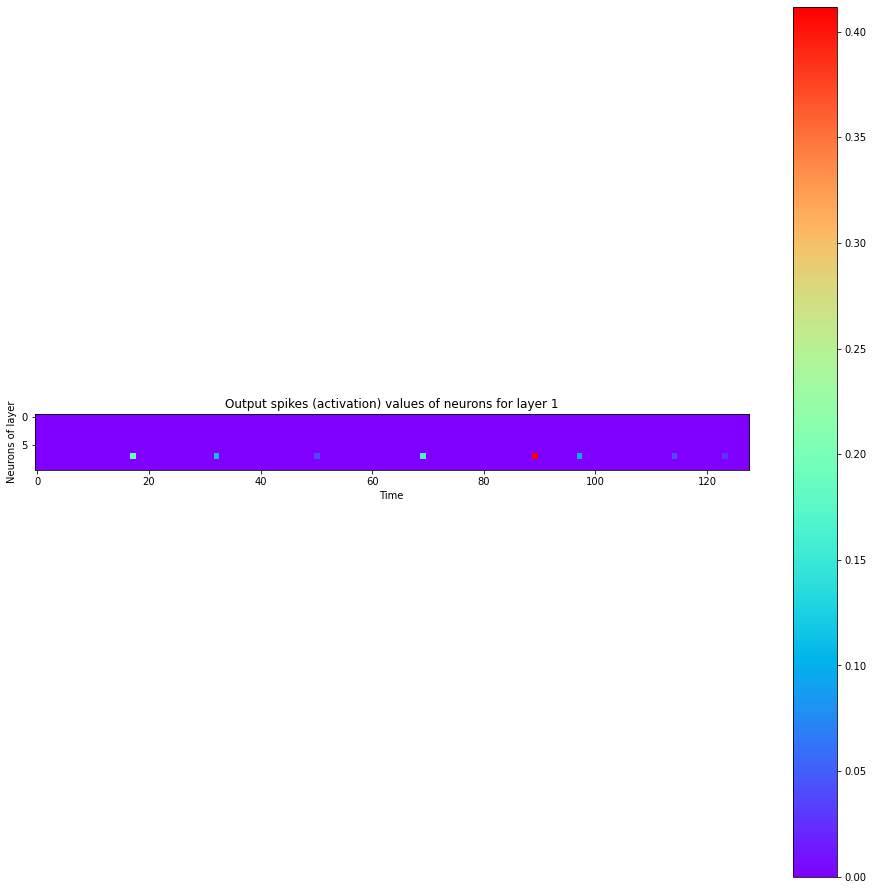

A hidden neuron that looks excited:


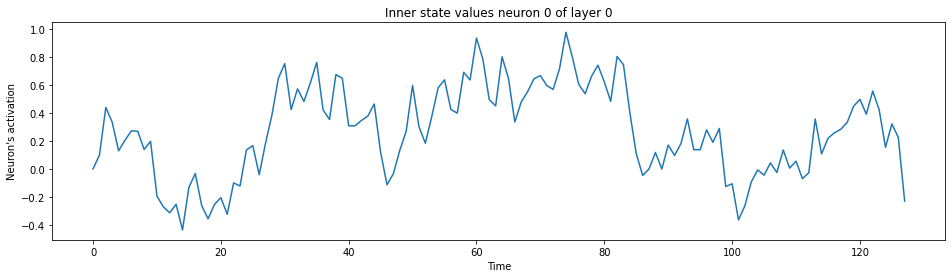

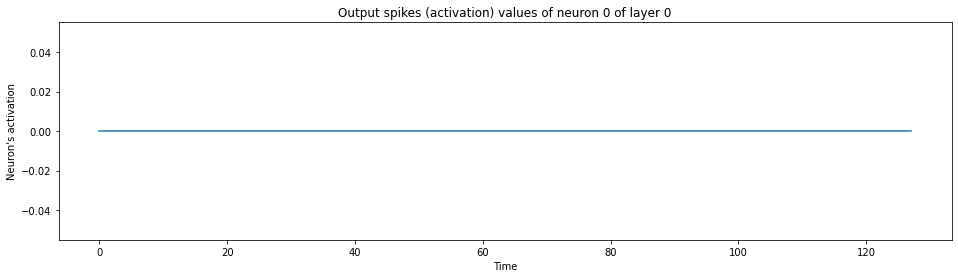

The output neuron of the label:


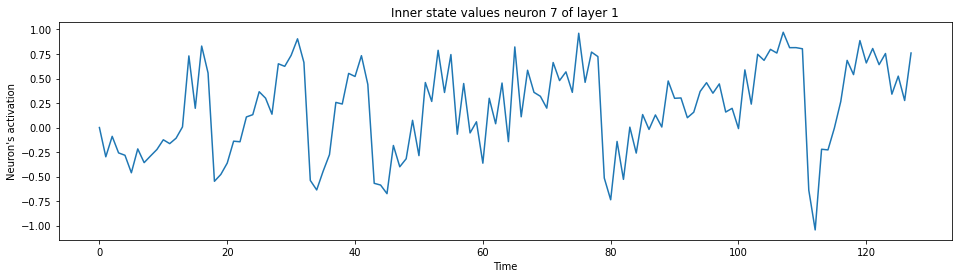

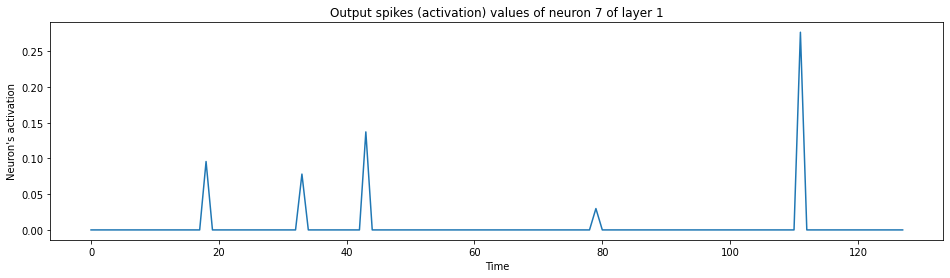

In [8]:
data, target = test_set_loader.__iter__().__next__()
 
# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()
 
# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)
